# Project 1 : Predicting the eye state of a subject from EEG data using supervised classification algorithms
*Arnaud Le Doeuff*

*Ignacio Dorado*

10/2020

## Libraries importation

In [1]:
# general python libraries
from scipy.io import arff
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

# sklearn functions
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# defined functions
import Eye_State_Functions as f

## Data importation

*Brief description of the dataset:*
All data is from one continuous EEG measurement with the Emotiv EEG Neuroheadset. The duration of the measurement was 117 seconds. The eye state was detected via a camera during the EEG measurement and added later manually to the file after analysing the video frames. '1' indicates the eye-closed and '0' the eye-open state. All values are in chronological order with the first measured value at the top of the data.

In [2]:
# Load the dataset from the csv file
data = pd.read_csv('EEG_Eye_State.csv', header=None)
# retrieve data as numpy array
values = data.values

## Data plotting

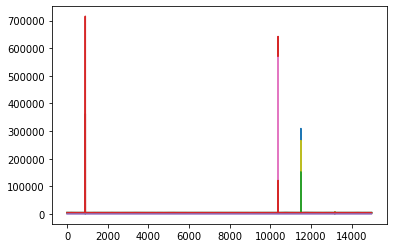

In [3]:
# plot all data in the same graph
plt.figure()
for i in range(values.shape[1]):
    plt.plot(values[:, i])
plt.show()

We can see some outliers that prevents us to get a proper view of the data. Lets  remove them.

## Outliers removal

In [4]:
# step over each EEG column
for i in range(values.shape[1] - 1):
    # calculate column mean and standard deviation
    data_mean = np.mean(values[:,i])
    data_std = np.std(values[:,i])
    # define outlier bounds
    cut_off = data_std * 4
    lower = data_mean - cut_off
    upper = data_mean + cut_off
    # remove too small
    too_small = [j for j in range(values.shape[0]) if values[j,i] < lower]
    values = np.delete(values, too_small, 0)
    print('>deleted %d rows' % len(too_small))
    # remove too large
    too_large = [j for j in range(values.shape[0]) if values[j,i] > upper]
    values = np.delete(values, too_large, 0)
    print('>deleted %d rows' % len(too_large))
    
# save the results to a new file
np.savetxt('EEG_Eye_State_no_outliers.csv', values, delimiter=',')

>deleted 0 rows
>deleted 1 rows
>deleted 2 rows
>deleted 1 rows
>deleted 0 rows
>deleted 142 rows
>deleted 0 rows
>deleted 48 rows
>deleted 0 rows
>deleted 153 rows
>deleted 0 rows
>deleted 43 rows
>deleted 0 rows
>deleted 0 rows
>deleted 0 rows
>deleted 15 rows
>deleted 0 rows
>deleted 5 rows
>deleted 10 rows
>deleted 0 rows
>deleted 21 rows
>deleted 53 rows
>deleted 0 rows
>deleted 12 rows
>deleted 58 rows
>deleted 53 rows
>deleted 0 rows
>deleted 59 rows


Now we load the data without the outliers from the new file

In [5]:
data = pd.read_csv('EEG_Eye_State_no_outliers.csv', header=None)
values = data.values

## Data plotting (no outliers)

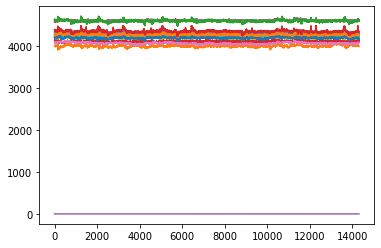

In [6]:
# plot all data in the same graph
plt.figure()
for i in range(values.shape[1]):
    plt.plot(values[:, i])
plt.show()

We can not get a good view of them because they overlap and the target variable is 1 or 0, so we plot every feature in a different graph, together with the target variable

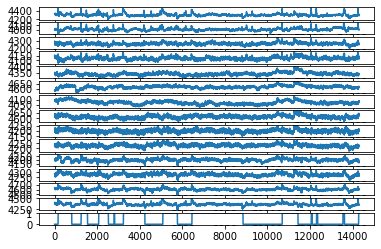

In [7]:
# plot each feature in a different graph
plt.figure()
for i in range(values.shape[1]):
    plt.subplot(values.shape[1], 1, i+1)
    plt.plot(values[:, i])
plt.show()

## Non Temporal Data Split

We split without taking into account any temporal order

In [8]:
np.random.shuffle(values)
split_size = round(values.shape[0]*0.7)
X_train = values[:split_size, :-1]
y_train = values[:split_size, -1]
X_test = values[split_size:, :-1]
y_test = values[split_size:, -1]

In [9]:
closed_eyes = np.sum(y_train)
open_eyes = y_train.shape[0] - closed_eyes
print('The amount of closed eyes examples in the training set is: ' + str(closed_eyes))
print(str(closed_eyes/y_train.shape[0]) + '% of the set')
print('The amount of open eyes examples in the training set is: ' + str(open_eyes))
print(str(open_eyes/y_train.shape[0]) + '% of the set')

The amount of closed eyes examples in the training set is: 4513.0
0.4507140717067812% of the set
The amount of open eyes examples in the training set is: 5500.0
0.5492859282932188% of the set


Our data is slightly unbalanced, but it should not be a problem. 55-45 is still enough balanced for us to keep working as usual and choose accuracy as our performance meassure. A cross validation function using the accuracy is implemented in Eye_State_Functions.py

Support Vector Machine (linear SVC)

In [10]:
model = svm.SVC()
print(f.My_Cross_Validation(X_train, y_train, model))

0.6071107560171777


Random Forest

In [11]:
model = RandomForestClassifier()
print(f.My_Cross_Validation(X_train, y_train, model))

0.9161090582243083


K-neareast Neighbors (KNN)

In [12]:
model = KNeighborsClassifier(n_neighbors=3)
print(f.My_Cross_Validation(X_train, y_train, model))

0.9648457005892341


## Temporal Data Split

The previous approch give us great result, but is methodologicaly wrong. When shuffling the examples we are using information from the future to predict examples from the past. Lets try do it without shuffing the dataset and respecting the order in which the measurements where taken

In [13]:
data = pd.read_csv('EEG_Eye_State_no_outliers.csv', header=None)
values = data.values

split_size = round(values.shape[0]*0.7)
X_train = values[:split_size, :-1]
y_train = values[:split_size, -1]
X_test = values[split_size:, :-1]
y_test = values[split_size:, -1]

Support Vector Machine (Linear SVC)

In [15]:
model = svm.SVC()
print(f.My_Cross_Validation(X_train, y_train, model))

0.4122640567262558


Random Forest

In [16]:
model = RandomForestClassifier()
print(f.My_Cross_Validation(X_train, y_train, model))

0.5295116348746631


K-nearest neighbors (KNN)

In [17]:
model = KNeighborsClassifier(n_neighbors=3)
print(f.My_Cross_Validation(X_train, y_train, model))

0.5602716468590832


## The solution: Walk-Forward Validation

Now that we respect the temporal order, we get very poor results, but we can do better if we allow the model to see previous information from the past (but never from the future). We can do that using Walk-forward validation which evaluate a new model for each new example. An implementation of this function is written in Eye_State_Functions.py
From now on, will use just KNN since it has proven to be the best classifier in this dataset

In [18]:
model = KNeighborsClassifier(n_neighbors=3)
print(f.My_Walk_Forward_Validation (X_train, y_train, model, 10))

1.0


Now we get the best result

## Feature importance

## Feature selection

We obtained pretty good results with the KNN algorithm, but we sill can improve them, as well as computational time. Lets try some feature selection

In [19]:
for i in range(X_train.shape[1]):
    print(str(i+1) + ' features selected')
    
    kbest = SelectKBest (f_classif, k=i+1)
    new_features = kbest.fit_transform(X_train, y_train)
    
    model = KNeighborsClassifier(n_neighbors=3)
    
    print(f.My_Walk_Forward_Validation (new_features, y_train, model, 10))

1 features selected
1.0
2 features selected
1.0
3 features selected
1.0
4 features selected
1.0
5 features selected
1.0
6 features selected
1.0
7 features selected
1.0
8 features selected
1.0
9 features selected
1.0
10 features selected
1.0
11 features selected
1.0
12 features selected
1.0
13 features selected
1.0
14 features selected
1.0


It seems like 1 feature is important enough to let us predict every example if we know the previous 10 measurments

*Disclaimer: it looks like something went wrong here, but we could not figure it out

## TPOT optimization

In [20]:
from tpot import TPOTClassifier

tpot = TPOTClassifier(generations=5, population_size=10, verbosity=2)
tpot.fit(X_train, y_train)

c:\users\nacho\appdata\local\programs\python\python37\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")



Generation 1 - Current best internal CV score: 0.5780399829825692
Generation 2 - Current best internal CV score: 0.5780399829825692
Generation 3 - Current best internal CV score: 0.5795381852296481
Generation 4 - Current best internal CV score: 0.5795381852296481
Generation 5 - Current best internal CV score: 0.5799388828844645
Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=28, p=2, weights=distance)


TPOTClassifier(generations=5,
               log_file=<ipykernel.iostream.OutStream object at 0x000001AF25EA1388>,
               population_size=10, verbosity=2)

In [21]:
tpot.fitted_pipeline_.steps

[('kneighborsclassifier',
  KNeighborsClassifier(n_neighbors=28, weights='distance'))]

In [22]:
print(tpot.score(X_test, y_test))

0.4828711256117455
